In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import abspath

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
# Read in the 5-year data from the MSFT stock
df = pd.read_csv(abspath('../../../data/MSFT/MSFT-5-Year.csv'), header=0, index_col='Date', parse_dates=True)

df.columns.name = df.index.name
df.index.name = None

# Keep nothing but the date and the opening price in the df
df = df.filter(['Date', 'Open'])

df.head()

Date,Open
2017-03-01,64.129997
2017-03-02,64.690002
2017-03-03,63.990002
2017-03-06,63.970001
2017-03-07,64.190002


Date             Open
2017-03-01  64.129997
2017-03-02  64.690002
2017-03-03  63.990002
2017-03-06  63.970001
2017-03-07  64.190002


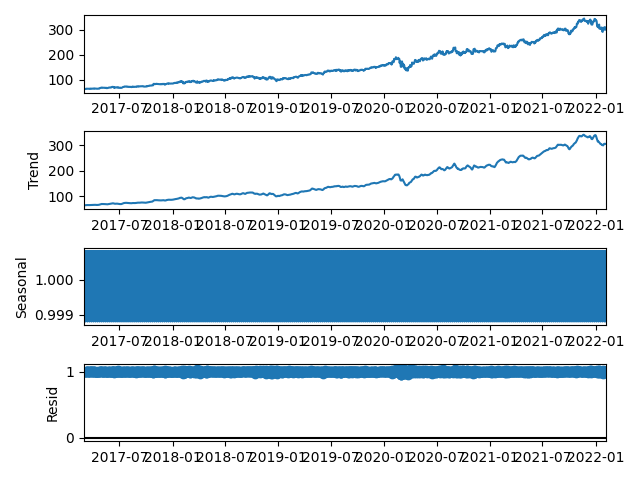

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_copy = df.copy()

print(df_copy.head())

result = seasonal_decompose(df_copy.asfreq('D', method='ffill'), model='multiplicative')
result.plot()
plt.show()

In [5]:
# Split the data into training and testing with a 75-25 split
train_size = int(len(df) * 0.975)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:]

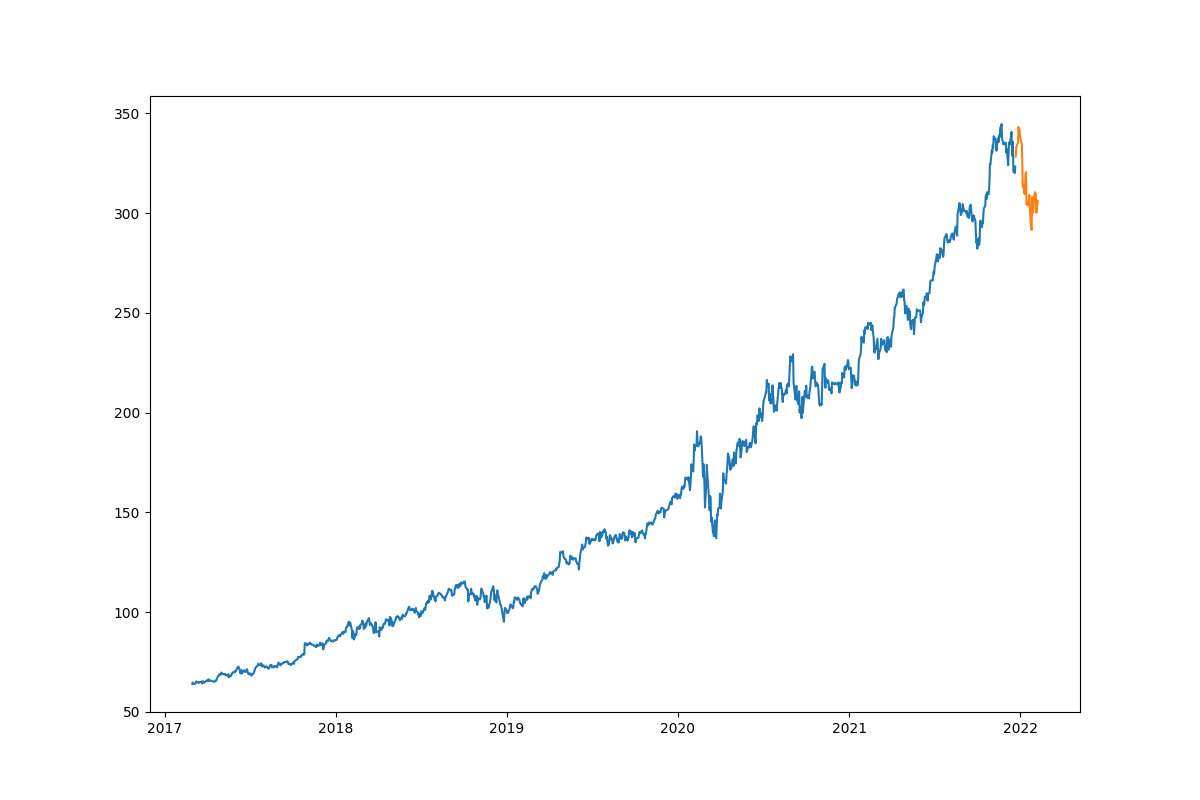

In [6]:
# Plot the training and testing data in the same figure
plt.figure(figsize=(12, 8))
plt.plot(train['Open'], label='Training Data')
plt.plot(test['Open'], label='Testing Data')

In [7]:
train.index = pd.DatetimeIndex(train.index).to_period('B')
train = train.asfreq('B')
test.index = pd.DatetimeIndex(test.index).to_period('B')
test = test.asfreq('B')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5851.033, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5857.989, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5855.528, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5854.549, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5863.525, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5849.433, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5847.548, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5849.381, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5851.728, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5851.430, Time=0.91 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5855.865, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.791 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1

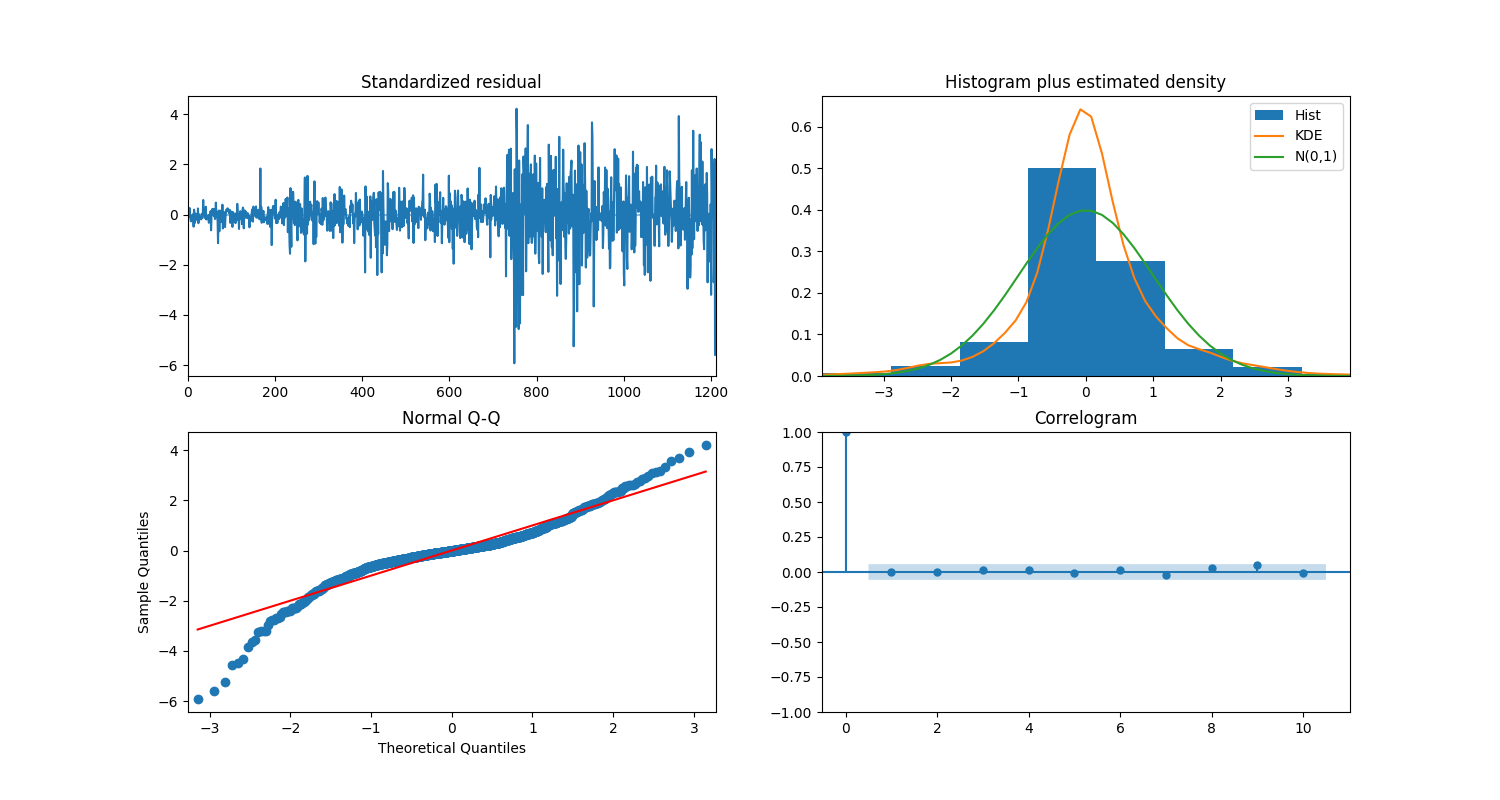

In [8]:
from pmdarima.arima import auto_arima

model = auto_arima(train, 
                      test='adf',       # use adftest to find optimal 'd'
                      trace=True,
                      error_action='raise',  
                      suppress_warnings=True, 
                      stepwise=True,
                      njobs=-1)

print(model.summary())
model.plot_diagnostics(figsize=(15,8))
plt.show()

In [9]:
model.fit(train)

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True)

<AxesSubplot:>

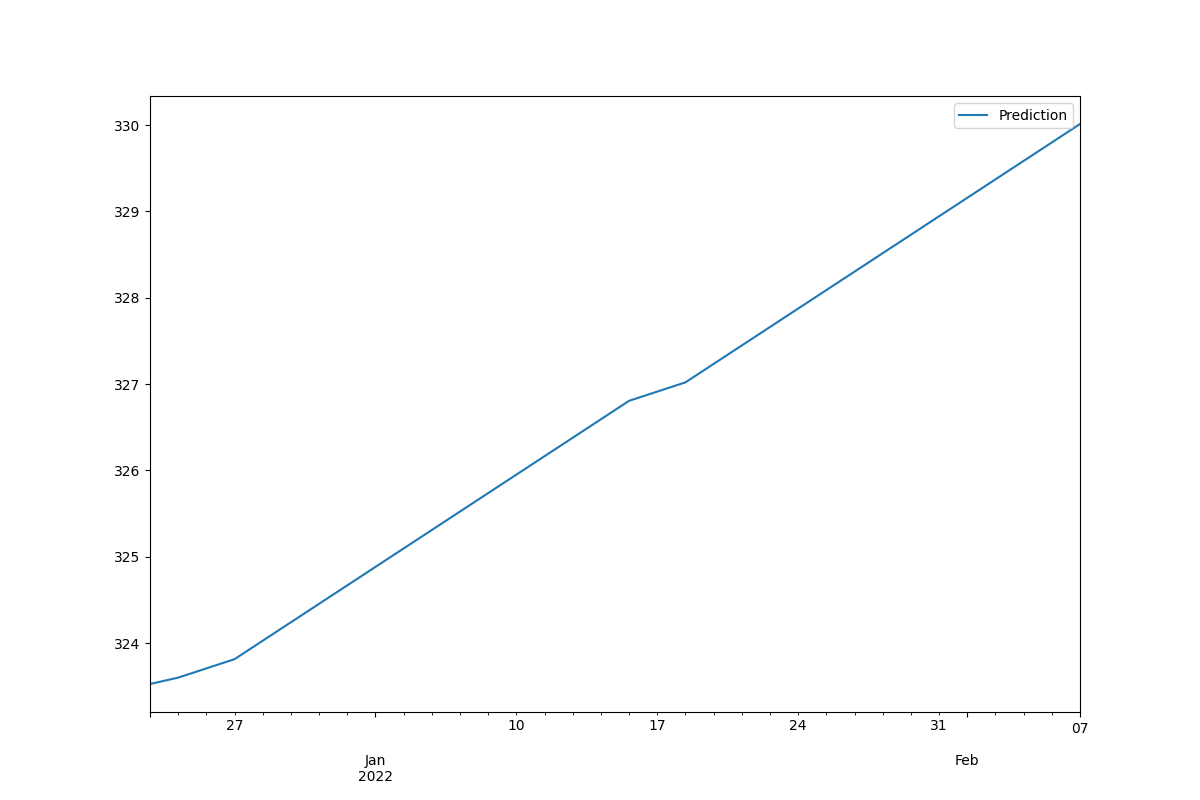

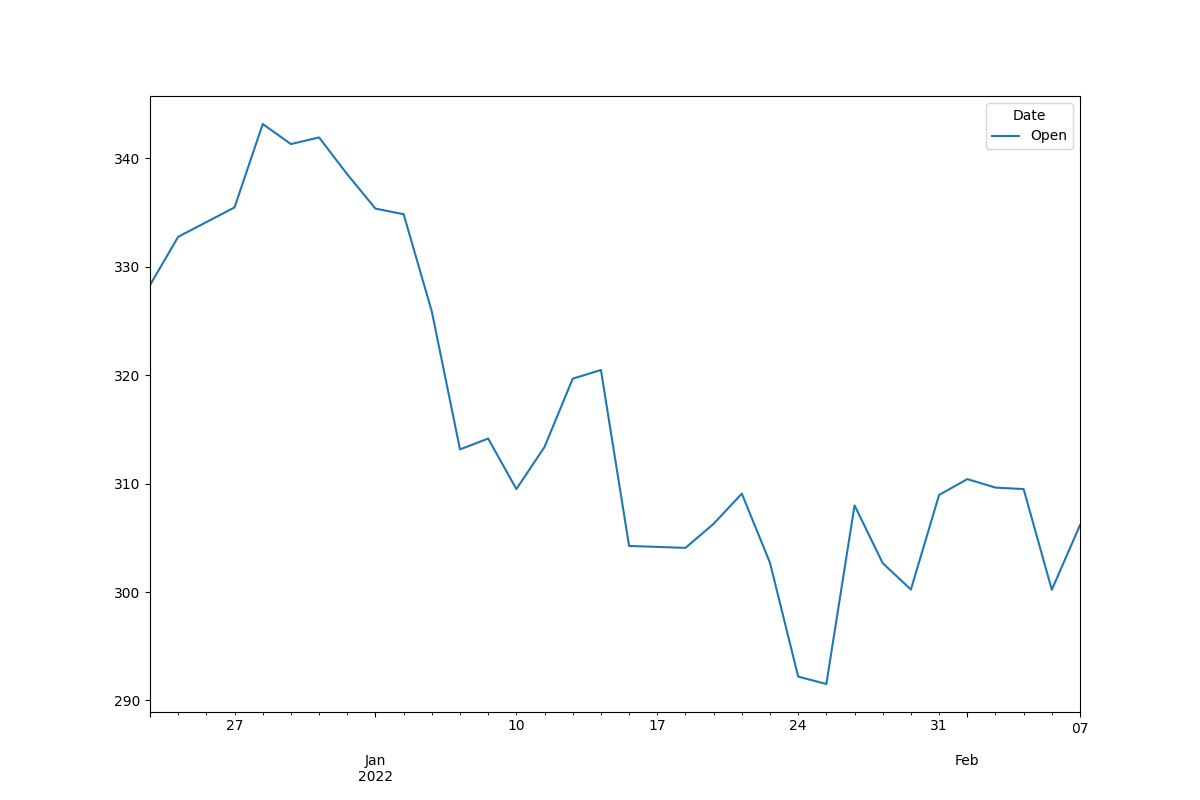

In [14]:
precast = model.predict(n_periods=len(test))

# Conver numpy.ndarray to pandas.dataframe
trainingLearned = pd.DataFrame(precast, index=test.index, columns=['Prediction'])
trainingLearned.plot(label='Learned', figsize=(12,8))
test.plot(label='Actual', figsize=(12,8))

In [10]:
precast = model.predict(n_periods=len(test))

trainingLearned = precast.to_frame()

trainingLearned.plot(label='Learned', figsize=(12,8))
plt.plot(train['Open'], label='Training Data')

AttributeError: 'numpy.ndarray' object has no attribute 'to_frame'

In [ ]:
# forecast = fitted.get_forecast(steps=test_size)

# forecast_df = forecast.predicted_mean.to_frame()

# # Rename the index to Date
# forecast_df.index.name = 'Date'

# forecast_df.columns.name = df.index.name
# forecast_df.index.name = None

# # Plot the forecast
# forecast_df.plot(label='Forecast', figsize=(12,8))
# plt.plot(test['Open'], label='Testing Data')


In [ ]:
# # Save the forecast_df to a csv file
# forecast_df.to_csv(abspath('../../../data/MSFT/MSFT-5-Year-Forecast.csv'), index_label='Date')